In [ ]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow transformers tf-keras datasets pyarrow
!pip install fsspec==2024.12.0 gcsfs==2024.12.0 --no-cache-dir

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device selected: {device}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import Dataset

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification



Device selected: cuda


In [3]:

from transformers import BertForSequenceClassification
import torch

num_labels = 28  # Based on GoEmotions emotion categories

from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted Successfully")

models = {}
for fold in range(1, 6):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification")
    model_path = f"/content/drive/MyDrive/Project/models/bert_fold_{fold}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    models[f"fold_{fold}"] = model

print("All fold models loaded successfully.")


Mounted at /content/drive
Google Drive mounted Successfully


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

All fold models loaded successfully.


In [4]:
eval_data = pd.read_parquet("/content/drive/My Drive/Project/go_emotions_test_preprocessed.parquet")
print("Evaluation Data Columns:", eval_data.columns)
print(eval_data.head())

Evaluation Data Columns: Index(['text', 'labels', 'id', 'cleaned_text'], dtype='object')
                                                text labels       id  \
0  I’m really sorry about your situation :( Altho...   [25]  eecwqtt   
1    It's wonderful because it's awful. At not with.    [0]  ed5f85d   
2  Kings fan here, good luck to you guys! Will be...   [13]  een27c3   
3  I didn't know that, thank you for teaching me ...   [15]  eelgwd1   
4  They got bored from haunting earth for thousan...   [27]  eem5uti   

                                        cleaned_text  
0  im really sorry situation although love name s...  
1                                    wonderful awful  
2      king fan good luck guy interesting game watch  
3          didnt know thank teaching something today  
4  got bored haunting earth thousand year ultimat...  


In [ ]:
from transformers import BertTokenizer

# 1. Initialing BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 2. Extracting texts and labels from evaluation data
eval_texts = eval_data["text"].tolist()  # or "cleaned_text" if you prefer
eval_labels = eval_data["labels"].tolist()

# 3. Tokenizing the evaluation texts
eval_encodings = tokenizer(eval_texts, truncation=True, padding=True, max_length=64)

# 4. Converting labels to multi-hot format
def multi_hot_encode(label_list, num_classes=28):
    result = torch.zeros((len(label_list), num_classes), dtype=torch.float)
    for i, labels in enumerate(label_list):
        result[i, labels] = 1.0
    return result

eval_multi_hot_labels = multi_hot_encode(eval_labels)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-5-25faec47ffef>:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  result[i, labels] = 1.0


In [6]:
from torch.utils.data import Dataset
import torch

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).float()
        return item


In [ ]:
import torch

def get_dynamic_batch_size(initial_batch_size=64, fallback_batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running batch size test on {device}")

    batch_size = initial_batch_size
    try:
        # Simulating a dummy BERT input: 
        dummy_input = torch.randint(0, 30522, (batch_size, 64), device=device)  # 30522 is BERT's vocab size
        dummy_mask = torch.ones((batch_size, 64), device=device)
        from transformers import BertModel
        model = BertModel.from_pretrained("bert-base-uncased").to(device)
        with torch.no_grad():
            model(input_ids=dummy_input, attention_mask=dummy_mask)
    except (RuntimeError, OSError) as e:
        if "out of memory" in str(e).lower() or "cannot allocate memory" in str(e).lower():
            print(f"Memory issue on {device}, reducing batch size to {fallback_batch_size}")
            batch_size = fallback_batch_size
            if device.type == 'cuda':
                torch.cuda.empty_cache()
        else:
            raise e
    return batch_size

batch_size = get_dynamic_batch_size()


Running batch size test on cuda


In [8]:
from torch.utils.data import DataLoader

pin_memory = torch.cuda.is_available()

eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)



In [9]:
import numpy as np
import ast

def labels_to_multi_hot(label_entry, num_classes=28):
    try:
        if isinstance(label_entry, str):
            label_list = ast.literal_eval(label_entry)
        else:
            label_list = label_entry

        multi_hot = np.zeros(num_classes, dtype=int)
        for lbl in label_list:
            multi_hot[int(lbl)] = 1
        return multi_hot
    except Exception as e:
        print("Label processing error:", label_entry, e)
        return np.zeros(num_classes, dtype=int)

eval_data['multi_hot_labels'] = eval_data['labels'].apply(labels_to_multi_hot)

In [ ]:
from transformers import AutoTokenizer
import torch

# Initializing tokenizer 
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenizing evaluation text
eval_encodings = tokenizer(
    eval_data["cleaned_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Converting multi-hot labels for evaluation
eval_labels = torch.tensor(eval_data['multi_hot_labels'].tolist()).float()

# Input tensors
input_ids = eval_encodings["input_ids"]
attention_mask = eval_encodings["attention_mask"]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-10-7866acf7ea13>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  eval_labels = torch.tensor(eval_data['multi_hot_labels'].tolist()).float()


In [11]:
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


In [ ]:
import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
os.makedirs("plots", exist_ok=True)

# Logging
log_file = "eval_log.txt"
with open(log_file, "w") as f:
    f.write(f"Evaluation started at {time.ctime()}\n")

def log(msg):
    print(msg)
    with open(log_file, "a") as f:
        f.write(msg + "\n")

# Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)


In [ ]:
import numpy as np
import ast
label_cols = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire",
    "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy",
    "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

def labels_to_multi_hot(label_entry, num_classes=28):
    try:
        if isinstance(label_entry, str):
            label_list = ast.literal_eval(label_entry)
        else:
            label_list = label_entry
        multi_hot = np.zeros(num_classes, dtype=int)
        for lbl in label_list:
            multi_hot[int(lbl)] = 1
        return multi_hot
    except Exception as e:
        print("Label processing error:", label_entry, e)
        return np.zeros(num_classes, dtype=int)

# Converting to 28-label format
multi_hot_labels = eval_data["labels"].apply(labels_to_multi_hot)
eval_data[label_cols] = pd.DataFrame(multi_hot_labels.tolist(), index=eval_data.index)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

# Initializing storage
all_logits = []
all_labels = []
eval_threshold = 0.5

for fold in range(1, 6):
    print(f"\nEvaluating Fold {fold} Model...")
    model = models[f"fold_{fold}"]
    model.eval()

    fold_logits = []

    with torch.no_grad():
        for batch in eval_loader:
            input_ids, attention_mask, _ = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            fold_logits.append(probs)

    all_logits.append(np.vstack(fold_logits))
    all_labels.append(eval_labels.numpy())

# Calculating metrics
per_label_results = []
fold_wise_accuracy = []

for fold_idx, (probs, targets) in enumerate(zip(all_logits, all_labels)):
    # Identifying the rare label indices
    rare_label_indices = [emotion_labels.index(lbl) for lbl in ["grief", "relief", "pride"]]

    # Ensuring rare class probabilities aren't completely suppressed
    for i in rare_label_indices:
        probs[:, i] = np.maximum(probs[:, i], 0.05)

    # Per-label thresholds
    thresholds = np.full(len(emotion_labels), eval_threshold)  # default 0.5
    for i in rare_label_indices:
        thresholds[i] = 0.1  # more lenient

    # Applying per-label thresholding
    preds = (probs >= thresholds).astype(int)

    # Per-label metrics
    fold_prec = precision_score(targets, preds, average=None, zero_division=0)
    fold_rec = recall_score(targets, preds, average=None, zero_division=0)
    fold_f1 = f1_score(targets, preds, average=None, zero_division=0)
    fold_acc = (preds == targets).mean(axis=0)  # Per-label accuracy

    # Subset accuracy (exact match across all 28 labels)
    subset_acc = accuracy_score(targets, preds)
    fold_wise_accuracy.append(subset_acc)

    df = pd.DataFrame({
        "emotion": label_cols,
        "precision": fold_prec,
        "recall": fold_rec,
        "f1": fold_f1,
        "accuracy": fold_acc,
        "fold": fold_idx + 1
    })
    per_label_results.append(df)

# Combining all per-label results
per_label_df = pd.concat(per_label_results, ignore_index=True)
mean_per_label = per_label_df.groupby("emotion")[["precision", "recall", "f1", "accuracy"]].mean().reset_index()

print("\nAverage Per-Label Metrics Across Folds:")
display(mean_per_label.round(4))

# Fold-wise strict (subset) accuracy
for fold, acc in enumerate(fold_wise_accuracy, 1):
    print(f"Fold {fold} Subset Accuracy (strict match): {acc:.4f}")

print(f"\nAverage Subset Accuracy Across Folds: {np.mean(fold_wise_accuracy):.4f}")



Evaluating Fold 1 Model...

Evaluating Fold 2 Model...

Evaluating Fold 3 Model...

Evaluating Fold 4 Model...

Evaluating Fold 5 Model...

Average Per-Label Metrics Across Folds:


,emotion,precision,recall,f1,accuracy
0,admiration,0.7263,0.6544,0.6878,0.9448
1,amusement,0.8026,0.8402,0.8208,0.9822
2,anger,0.5704,0.4152,0.4794,0.9671
3,annoyance,0.5349,0.2256,0.3167,0.9427
4,approval,0.5700,0.2177,0.3140,0.9387
5,caring,0.5733,0.2000,0.2959,0.9763
6,confusion,0.6620,0.1673,0.2669,0.9741
7,curiosity,0.7282,0.0444,0.0835,0.9491
8,desire,0.6920,0.2554,0.3717,0.9868
9,disappointment,0.6154,0.1828,0.2808,0.9741


Fold 1 Subset Accuracy (strict match): 0.5145
Fold 2 Subset Accuracy (strict match): 0.5075
Fold 3 Subset Accuracy (strict match): 0.5056
Fold 4 Subset Accuracy (strict match): 0.5095
Fold 5 Subset Accuracy (strict match): 0.5038

Average Subset Accuracy Across Folds: 0.5082
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


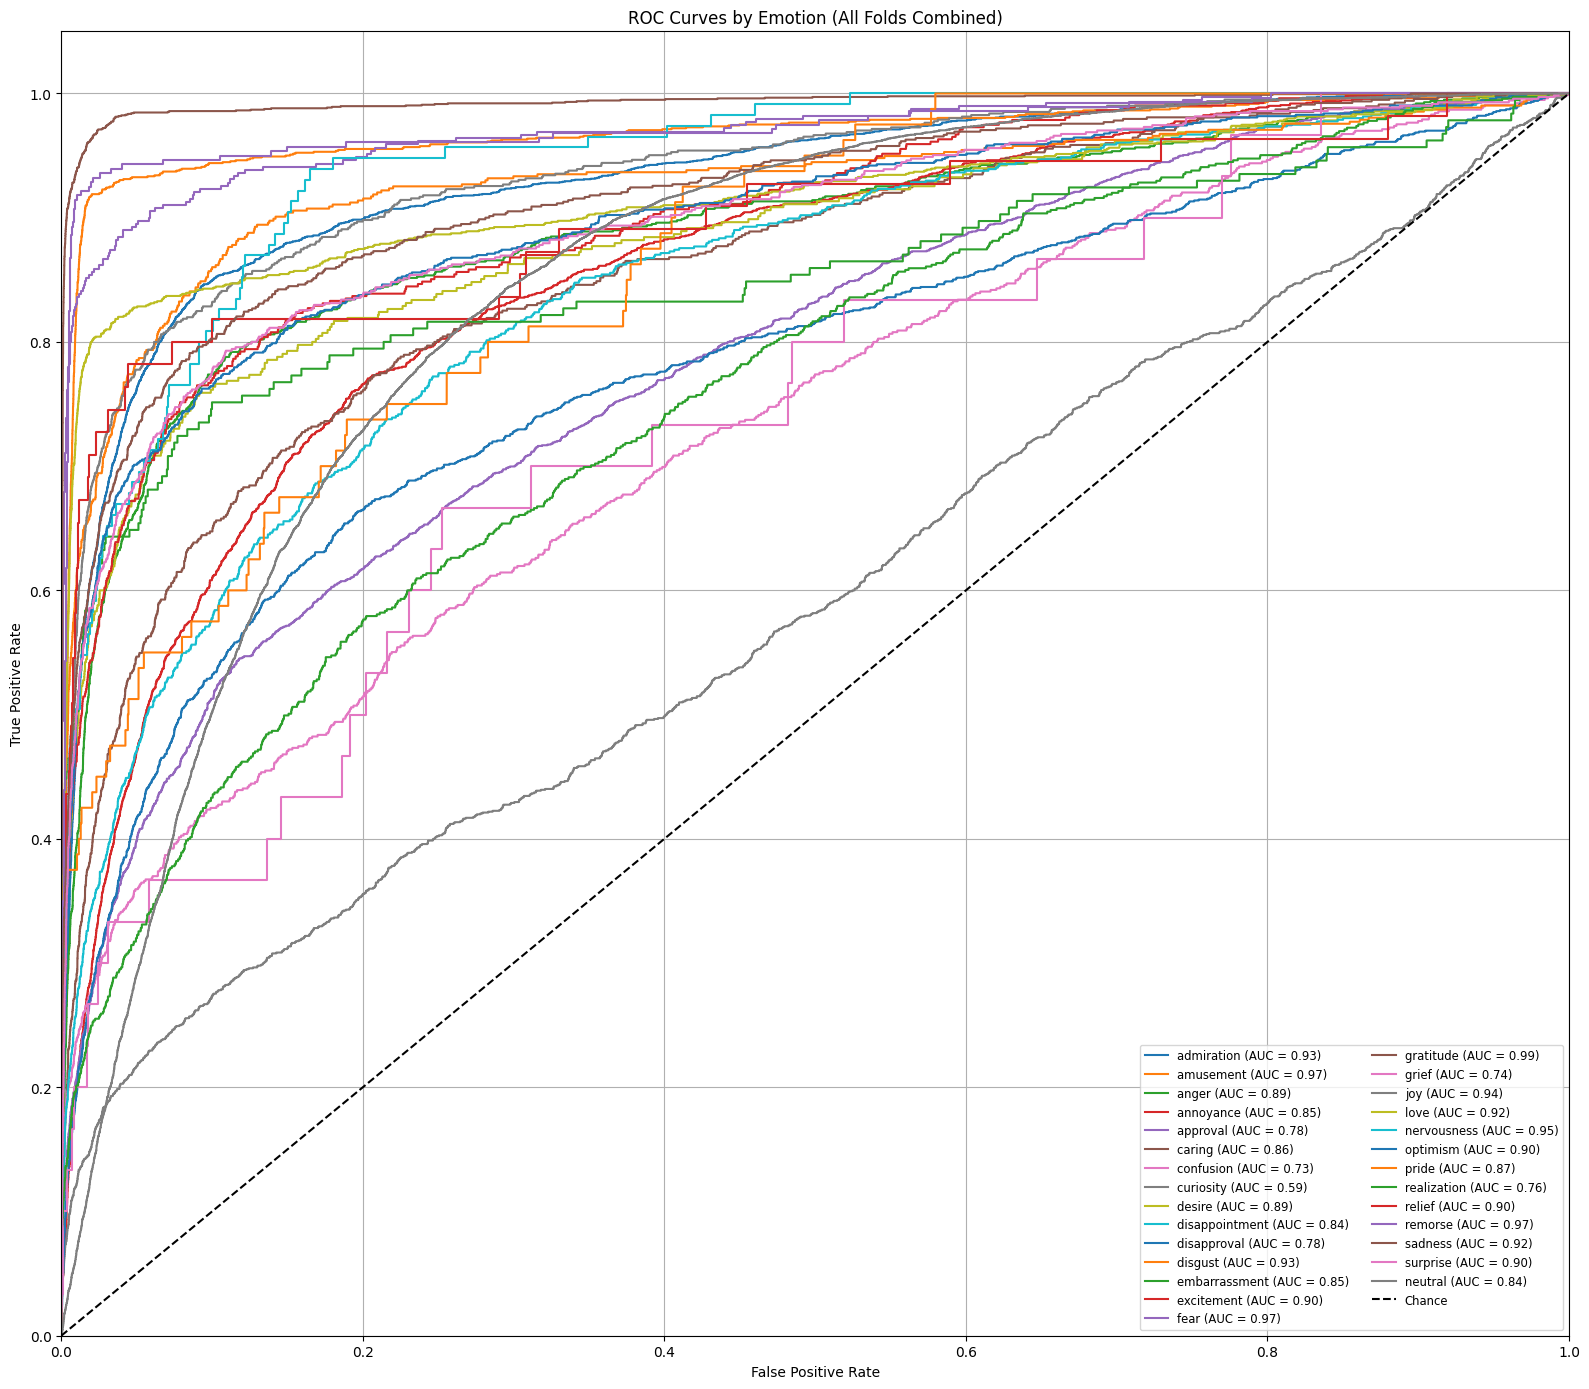

'/content/drive/MyDrive/Project/roc_curves_all_emotions.png'

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Aggregating logits and true labels across all folds
logits_all = np.concatenate(all_logits, axis=0)
labels_all = np.concatenate(all_labels, axis=0)

# Plotting ROC curve for each emotion
plt.figure(figsize=(16, 14))

for i in range(28):
    fpr, tpr, _ = roc_curve(labels_all[:, i], logits_all[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{emotion_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Emotion (All Folds Combined)")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/roc_curves_all_emotions.png")
plt.show()

# Saving to Drive
import shutil
shutil.copy("plots/roc_curves_all_emotions.png", "/content/drive/MyDrive/Project/roc_curves_all_emotions.png")


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

# Global threshold tuning
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    preds = (logits_all > t).astype(int)
    f1 = f1_score(labels_all, preds, average="macro", zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Global Threshold: {best_threshold:.2f} | Macro F1: {best_f1:.4f}")

# Per-label threshold tuning
label_thresholds = []
label_f1s = []

for i in range(28):
    best_t, best_f1_i = 0.5, 0
    for t in thresholds:
        pred_i = (logits_all[:, i] > t).astype(int)
        f1_i = f1_score(labels_all[:, i], pred_i, zero_division=0)
        if f1_i > best_f1_i:
            best_f1_i = f1_i
            best_t = t
    label_thresholds.append(best_t)
    label_f1s.append(best_f1_i)
    print(f"{emotion_labels[i]:<15} | Best Thresh: {best_t:.2f} | F1: {best_f1_i:.4f}")

# Saving per-label thresholds & F1s
threshold_df = pd.DataFrame({
    "Emotion": emotion_labels,
    "Best Threshold": label_thresholds,
    "Best F1 Score": label_f1s
})
threshold_df.to_csv("optimal_thresholds.csv", index=False)
threshold_df.to_csv("/content/drive/MyDrive/Project/optimal_thresholds.csv", index=False)
print("\nSaved optimal thresholds to Drive and local as 'optimal_thresholds.csv'")


Best Global Threshold: 0.16 | Macro F1: 0.4619
admiration      | Best Thresh: 0.30 | F1: 0.6897
amusement       | Best Thresh: 0.35 | F1: 0.8267
anger           | Best Thresh: 0.33 | F1: 0.5232
annoyance       | Best Thresh: 0.22 | F1: 0.4184
approval        | Best Thresh: 0.14 | F1: 0.3785
caring          | Best Thresh: 0.13 | F1: 0.3652
confusion       | Best Thresh: 0.12 | F1: 0.2998
curiosity       | Best Thresh: 0.10 | F1: 0.1764
desire          | Best Thresh: 0.17 | F1: 0.4553
disappointment  | Best Thresh: 0.23 | F1: 0.3405
disapproval     | Best Thresh: 0.18 | F1: 0.3516
disgust         | Best Thresh: 0.42 | F1: 0.6029
embarrassment   | Best Thresh: 0.23 | F1: 0.4952
excitement      | Best Thresh: 0.28 | F1: 0.4810
fear            | Best Thresh: 0.39 | F1: 0.7497
gratitude       | Best Thresh: 0.44 | F1: 0.9244
grief           | Best Thresh: 0.50 | F1: 0.0000
joy             | Best Thresh: 0.29 | F1: 0.6051
love            | Best Thresh: 0.14 | F1: 0.7527
nervousness     | Best

<ipython-input-25-8486a599c3b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="emotion", y="best_threshold", data=df_summary, palette="coolwarm")


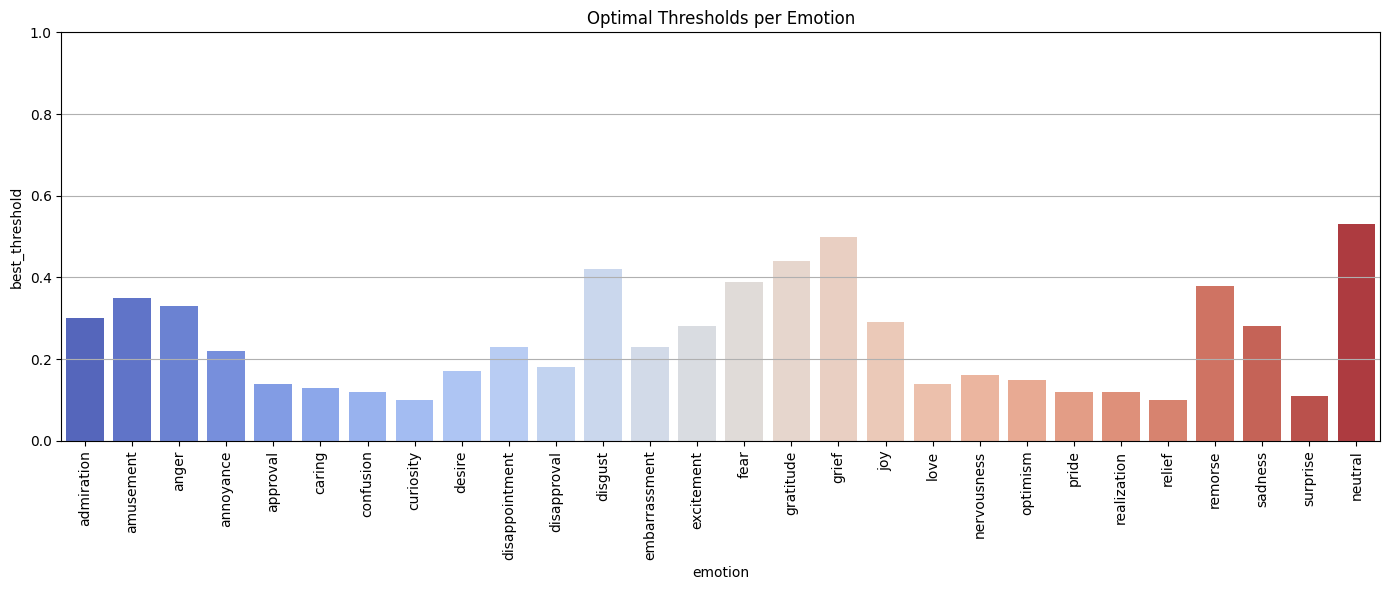

<ipython-input-25-8486a599c3b4>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="emotion", y="f1_score", data=df_summary, palette="mako")


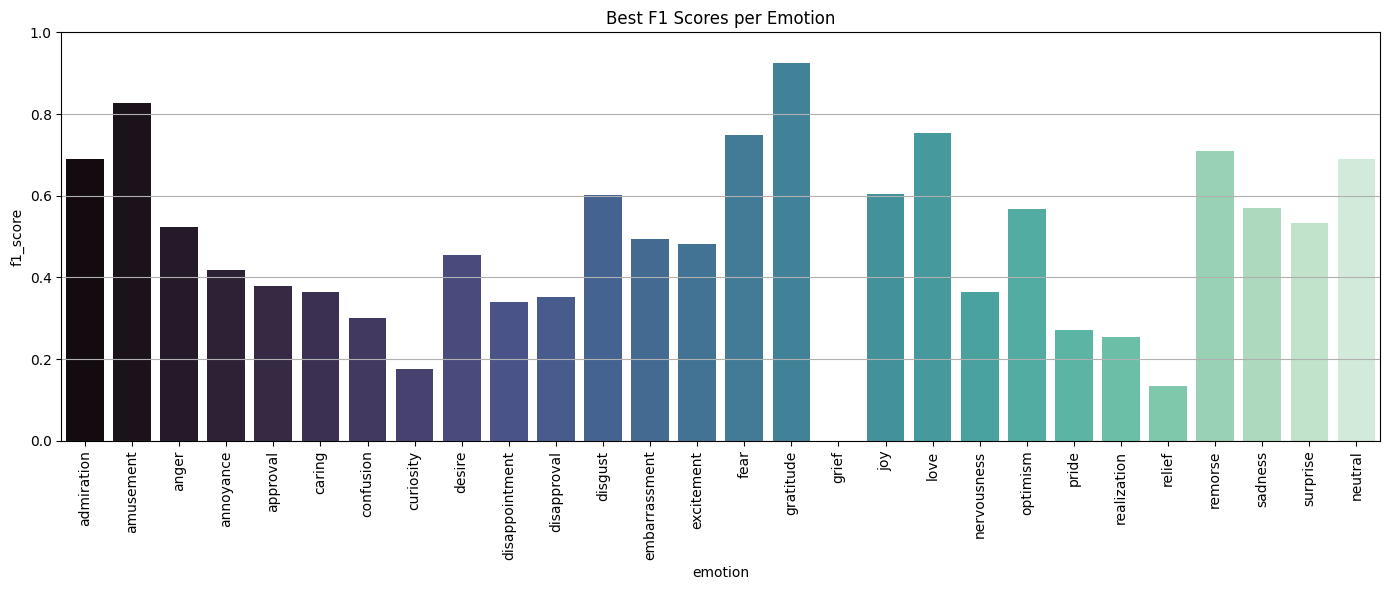

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_summary = pd.read_csv("/content/drive/MyDrive/Project/emotion_thresholds.csv")
best_thresholds = df_summary["best_threshold"].values
label_names = df_summary["emotion"].tolist()

RARE_LABELS = {"grief", "relief", "pride", "nervousness", "embarrassment", "remorse"}
for i, label in enumerate(label_names):
    if label in RARE_LABELS:
        best_thresholds[i] = min(best_thresholds[i], 0.1)

# Plotting Best Thresholds
plt.figure(figsize=(14, 6))
sns.barplot(x="emotion", y="best_threshold", data=df_summary, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Optimal Thresholds per Emotion")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plotting F1 Scores
plt.figure(figsize=(14, 6))
sns.barplot(x="emotion", y="f1_score", data=df_summary, palette="mako")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Best F1 Scores per Emotion")
plt.tight_layout()
plt.grid(axis='y')
plt.show()
